<a href="https://www.kaggle.com/code/hydramst/water-pollution-lr?scriptVersionId=97813776" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt 
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_validate

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/water-pollution/Submission.csv
/kaggle/input/water-pollution/Target.csv
/kaggle/input/water-pollution/Train.csv
/kaggle/input/water-pollution/Test.csv


In [2]:
DF_train = pd.read_csv('/kaggle/input/water-pollution/Train.csv', delimiter = ',')
DF_test = pd.read_csv('/kaggle/input/water-pollution/Test.csv', delimiter = ',')
Target = pd.read_csv('/kaggle/input/water-pollution/Target.csv', delimiter = ',')
Submission = pd.read_csv('/kaggle/input/water-pollution/Submission.csv', delimiter = ',')


In [3]:
df = pd.concat([DF_train, DF_test])
df = df.drop(columns = ['Unnamed: 0','period', 'leather', 'rate', 'venue', 'code'], axis =1)
#df = df.join(Target['polution'])

## view categorical and numerical columns

In [4]:
cat_columns = []
num_columns = []

for column_name in df.columns:
    if (df[column_name].dtypes == object):
        cat_columns +=[column_name]
    else:
        num_columns +=[column_name]

print('categorical columns:\t ',cat_columns, '\n len = ',len(cat_columns))

print('numerical columns:\t ',  num_columns, '\n len = ',len(num_columns))


categorical columns:	  ['id', 'Country'] 
 len =  2
numerical columns:	  ['year', 'tourists', 'food', 'glass', 'metal', 'other', 'paper', 'plastic', 'green_waste', 'waste_recycling'] 
 len =  10


## OHE 

In [5]:
df = pd.get_dummies(df)

## Split back to test and train 


In [6]:
len_test = len(DF_test)
train = df.iloc[:-len_test]
test = df.iloc[-len_test:]
print(DF_train.shape[0], train.shape[0], DF_test.shape[0], test.shape[0])

2318 2318 122 122


In [7]:
X, y = train.values, Target['polution'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ridge LR

In [8]:

model = Ridge(alpha = 0.0005, max_iter=10000)

model.fit(X_train, y_train)

B0=model.intercept_
B=model.coef_

line='{:.2f}'.format(B0)
sign=['+','-']

features_names = df.columns
for p,(fn,b) in enumerate(zip(features_names,B)):
  if np.abs(b)>0:
    line=line+sign[int(0.5*(np.sign(b)-1))]+'{:.2f}*'.format(np.abs(b))+fn



y_predict=model.predict(X_test)

print('Ошибка на тестовых данных')
print('MSE: %.1f' % mse(y_test,y_predict))
print('RMSE: %.1f' % mse(y_test,y_predict,squared=False))
print('R2 : %.4f' %  r2_score(y_test,y_predict))

Ошибка на тестовых данных
MSE: 0.0
RMSE: 0.1
R2 : 0.3702


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.20188e-22): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


## Compare answers with real values

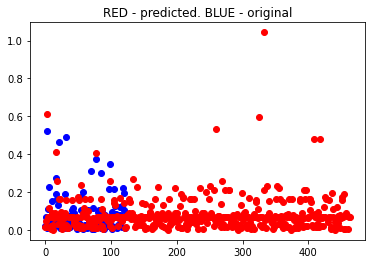

In [9]:
def plotGraph(y_test,y_predict,regressorName):
    if max(y_test) >= max(y_predict):
        my_range = int(max(y_test))
    else:
        my_range = int(max(y_predict))
    plt.scatter(range(len(y_test)), y_test, color='blue')
    plt.scatter(range(len(y_predict)), y_predict, color='red')
    plt.title(regressorName)
    plt.show()
    return


plotGraph(y_test[:122], y_predict, "RED - predicted. BLUE - original")

# Cross validation

In [10]:
def cross_val(model = model, X_train=X_train, y_train=y_train):
  scoring = {'R2': 'r2',
            '-MSE': 'neg_mean_squared_error',
            '-MAE': 'neg_mean_absolute_error',
            'Max': 'max_error'}


  scores = cross_validate(model, X_train, y_train,
                        scoring=scoring, cv=ShuffleSplit(n_splits=5, random_state=42) )

  print('Результаты Кросс-валидации')
  DF_cv_linreg = pd.DataFrame(scores)
  display(DF_cv_linreg)
  print('\n')
  print(DF_cv_linreg.mean()[2:])
  print('\n')

cross_val(model = model, X_train=X_train, y_train=y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.33852e-22): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.36214e-22): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.32399e-22): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.35145e-22): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


Результаты Кросс-валидации


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.34395e-22): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


,fit_time,score_time,test_R2,test_-MSE,test_-MAE,test_Max
0,0.244668,0.002517,0.090270,-0.008598,-0.052775,-0.557872
1,0.240319,0.002393,0.376726,-0.008391,-0.051727,-0.502624
2,0.283075,0.003113,0.414786,-0.004920,-0.047983,-0.253456
3,0.241151,0.002336,0.253780,-0.008248,-0.049196,-0.778461
4,0.265598,0.002353,0.360805,-0.006826,-0.048556,-0.495784




test_R2      0.299273
test_-MSE   -0.007396
test_-MAE   -0.050047
test_Max    -0.517639
dtype: float64




In [11]:
model = Ridge(alpha=0.0005, max_iter=10000)

model.fit(X_train, y_train)

y_predict = model.predict(test)

Submission['polution'] = y_predict
Submission

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.20188e-22): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but Ridge was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


,idx,polution
0,402,0.066112
1,748,0.068998
2,763,0.068998
3,942,0.089772
4,1258,0.068998
...,...,...
117,19447,0.228013
118,19458,0.091184
119,19464,0.057351
120,19699,0.063226


In [12]:
! rm /kaggle/working/water-pollution/Submission.csv
! mkdir /kaggle/working/water-pollution/
Submission['polution'][27] = 2.0

rm: cannot remove '/kaggle/working/water-pollution/Submission.csv': No such file or directory


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [13]:
Submission.to_csv('/kaggle/working/water-pollution/Submission.csv',index=False)

In [14]:
! mkdir ~/.kaggle
! touch ~/.kaggle/kaggle.json
! echo '{"username":"@","key": "@" }' > ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json

In [15]:
cat ~/.kaggle/kaggle.json

{"username":"@","key": "@" }


In [16]:
#! kaggle competitions submit -f /kaggle/working/water-pollution/Submission.csv -m "Message" sf-matml-2022-regression